


> #  Image Mosaicing


*   Akshay Bankar (2019201011)



In [0]:
!pip3 install opencv-contrib-python==3.3.0.9

     |████████████████████████████████| 14.8MB 207kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
import os

## Extract Features:


*   SIFT features : Detects salient, stable feature points in an image and provides a set of feature vector that characterize/describe a small image region around the point. These features are invariant to rotation and scale.
*   SURF features : To detect interest points, SURF uses an integer approximation of the determinant of Hessian blob detector. Its feature descriptor is based on the sum of the Haar wavelet response around the point of interest.



In [0]:
def getSIFTFeatures(image):
    shape = image.shape
    (height, width, dim) = shape 
    sift = cv.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, mask = None)
    return keypoints, descriptors

def getSURFFeatures(im):
    #gray scale image for reducing computation
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    surf = cv.xfeatures2d.SURF_create()
    kp, des = surf.detectAndCompute(gray, None)
    #img = cv.drawKeypoints(im, kp, None)
    return kp, des

## Find homography between two images

*   Detect keypoints and obtain corresponding features.

*   Feature Matching with FLANN : To match feature points between two images. SIFT and SURF descriptors represent the histogram of oriented gradient (of the Haar wavelet response for SURF) in a neighborhood and hence require histogram-based metrics for matching. Using KNN (k=2 here) finds the k best matches for each descriptor from a query set.

*   Find homography matrix : To find the left image, calculat mean of the matched points and thus decided which image will be on left and which will be on the right. Then find homography matrix using OpenCV's DLT based method which uses RANSAC to iteratively find best set of points among available for finding matrix.

In [0]:
def find_homography(image1, image2, factor = .2, feature_type = 'sift'):
    if feature_type == 'sift':
        keypoints1, descriptors1 = getSIFTFeatures(image1)
        keypoints2, descriptors2 = getSIFTFeatures(image2)
    elif feature_type == 'surf':
        keypoints1, descriptors1 = getSURFFeatures(image1)#getSIFTFeatures(image1)
        keypoints2, descriptors2 = getSURFFeatures(image2)#getSIFTFeatures(image2)
    good = []
    # Match features using FLANN based matching
    FLANN_INDEX_KDTREE = 0
    flann = cv.FlannBasedMatcher(indexParams = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5),
                                searchParams = dict(checks = 50))
    matches = flann.knnMatch(descriptors1, descriptors2, k = 2)
    matchesMask = [[0,0] for i in range(len(matches))]
    for m, n in matches:
        if m.distance < factor*n.distance:
            good.append([m])
    #print (good)
    img3 = cv.drawMatchesKnn(image1,keypoints1,image2,keypoints2,good, None, flags=2)
    plt.figure(figsize=(10,10))
    plt.imshow(img3)
    plt.show()
    if len(good) > 4:
        src = np.float32([keypoints1[m[0].queryIdx].pt for m in good]).reshape(-1, 2)
        dst = np.float32([keypoints2[m[0].trainIdx].pt for m in good]).reshape(-1, 2)
        x = False
        if src.mean() < dst.mean():
            src, dst = dst, src
            x=True
        H, s = cv.findHomography(dst, src, cv.RANSAC, 4)
        print ("Homography matrix",H)
        return H, x
    print("Less than 5 good points, cannot find homography matrix")
    return None, None

## Image stitching

*   After obtaining homography matrix apply a perspective transformation to image using 3x3 homography matrix which finds the target pixel as,

\begin{equation}
\texttt{dst} (x,y) = \texttt{src} \left ( \frac{M_{11} x + M_{12} y + M_{13}}{M_{31} x + M_{32} y + M_{33}} , \frac{M_{21} x + M_{22} y + M_{23}}{M_{31} x + M_{32} y + M_{33}} \right )
\end{equation}


In [0]:
def stitch_two_images(image1, image2, factor=.2, feature_type = 'sift'):
    homography,x  = find_homography(image1, image2, factor, feature_type)
    if homography is None:
        return None
    if x is True:
        print("swap")
        image1, image2 = image2, image1
    dst = cv.warpPerspective(image2,homography,(image1.shape[1] + image2.shape[1],image1.shape[0] + image2.shape[0]))
    orig_dst = dst
    dst[:image1.shape[0], :image1.shape[1]] = image1
    r = dst[:,:, 0 ]/1
    g = dst[:,:, 1 ]/1
    b = dst[:,:, 2 ]/1
    alpha = r+g+b
    pixel_preserve = (alpha<=5)
    for i in range (image1.shape[0]):
        for j in range(image1.shape[1]):
            if pixel_preserve[i][j]:
                dst[i][j] = orig_dst[i][j]
    temp = np.sum(dst, axis=2)
    dst = dst[~np.all(temp == 0, axis=1)]
    dst = dst[:,~np.all(temp == 0, axis=0)]
    return dst

def image_stitching(images, factor=.2, feature_type = 'sift'):
    right = images[0]
    images = images[1:]
    for image in images:
        right_img = stitch_two_images(image, right, factor, feature_type)
        if right_img is None :
            print("Could not perform stitching")
        else :
          plt.figure(figsize=(10,10))
          plt.imshow(right)
          plt.show()
          right = right_img
    #cv.imwrite("stichediamge.png", right)
    return right

## Mosaicing using SIFT features

*  On Given test images
*  On images captured from my camera



4

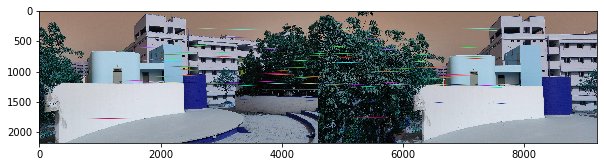

Homography matrix [[ 1.64304474e+00 -1.13744484e-02 -2.44178730e+03]
 [ 1.60980101e-01  1.41264399e+00 -5.30941637e+02]
 [ 1.41167431e-04  2.83016260e-06  1.00000000e+00]]


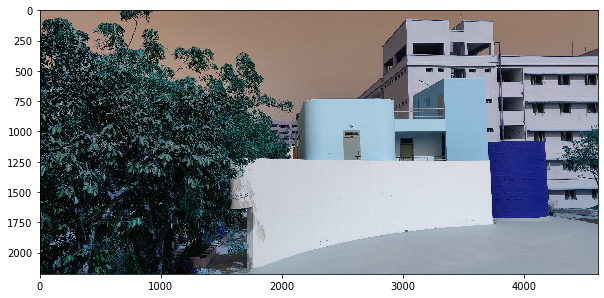

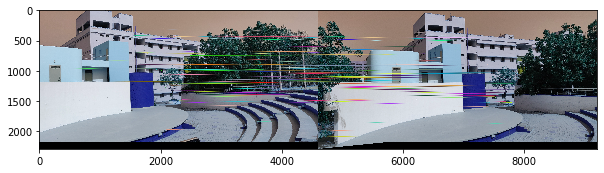

Homography matrix [[ 1.43591864e+00 -3.86605741e-03 -1.56569714e+03]
 [ 1.08096432e-01  1.26255000e+00 -3.11885588e+02]
 [ 9.65950497e-05  1.90728309e-06  1.00000000e+00]]


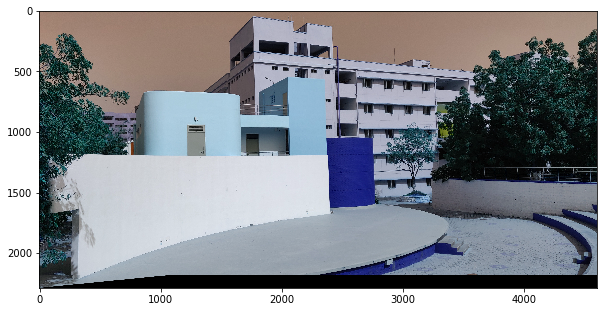

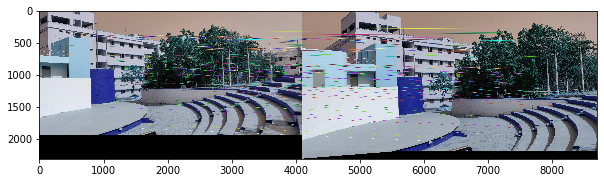

Homography matrix [[ 1.10874886e+00 -2.87161386e-03 -7.84661328e+02]
 [ 6.06220980e-02  1.01918646e+00 -1.55440790e+02]
 [ 5.38441235e-05  4.93989749e-06  1.00000000e+00]]


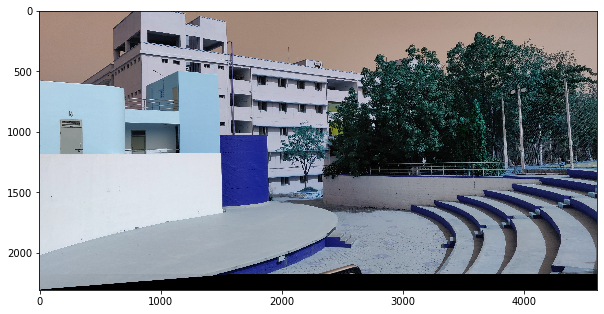

6

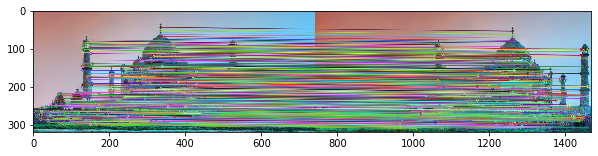

Homography matrix [[ 9.99967662e-01 -3.04963554e-05 -1.82981508e+02]
 [ 4.53002613e-06  9.99973476e-01 -1.00003316e+01]
 [-1.91297109e-09 -6.55296601e-08  1.00000000e+00]]


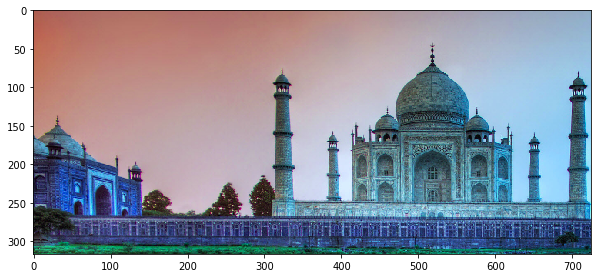

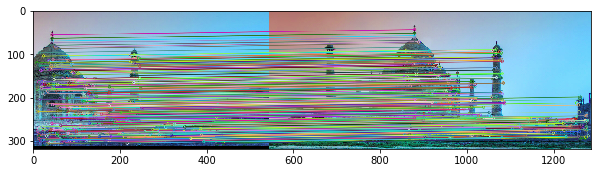

Homography matrix [[ 1.00000003e+00  3.37557770e-08 -2.92000017e+02]
 [ 1.88070185e-08  1.00000007e+00  1.19999866e+01]
 [-2.95186797e-11  2.07109425e-10  1.00000000e+00]]


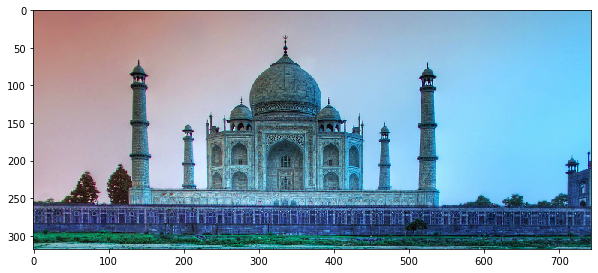

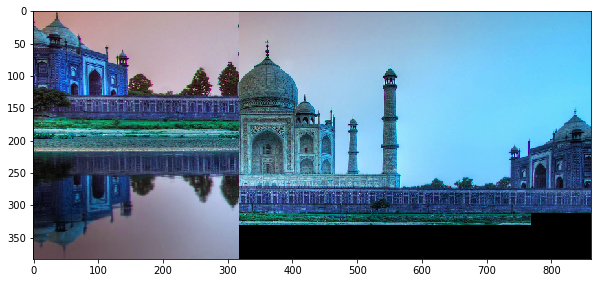

Less than 5 good points, cannot find homography matrix
Could not perform stitching


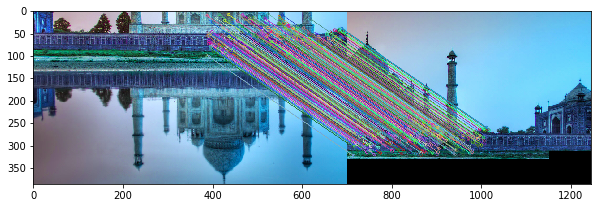

Homography matrix [[ 9.99999215e-01 -3.86438763e-07 -3.78999664e+02]
 [-2.45535116e-07  9.99998768e-01  2.21000023e+02]
 [-9.37015220e-10 -2.43296793e-09  1.00000000e+00]]
swap


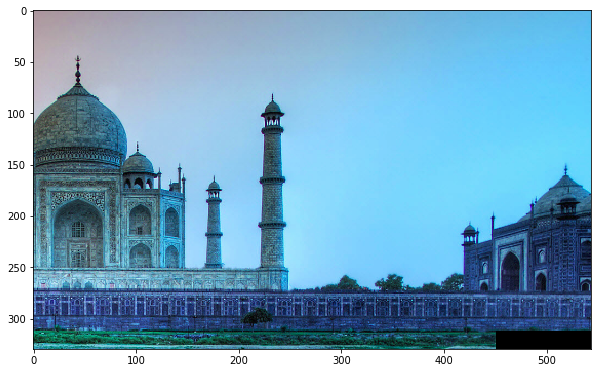

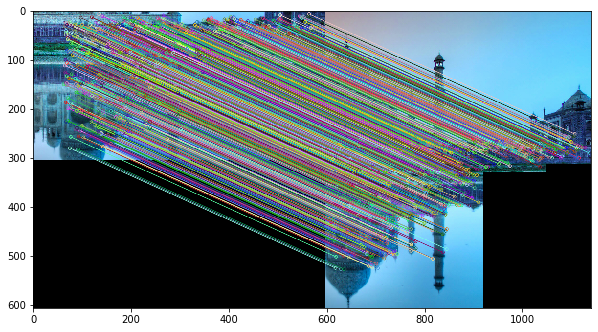

Homography matrix [[ 1.00008464e+00  3.56387693e-05  5.39903829e+01]
 [-5.44808464e-06  1.00007652e+00 -2.45017567e+02]
 [ 5.26878534e-08  2.00158255e-07  1.00000000e+00]]


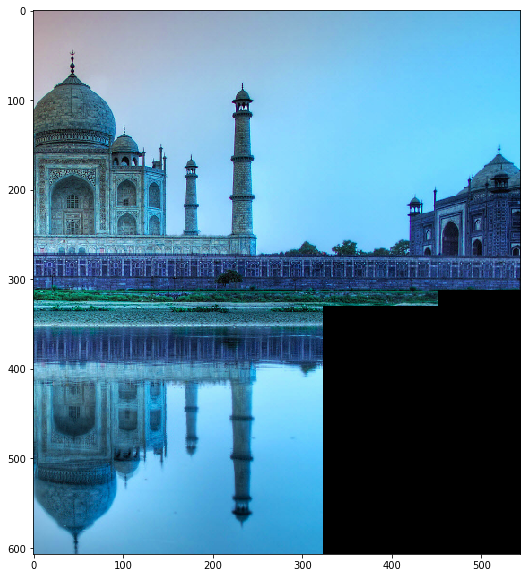

2

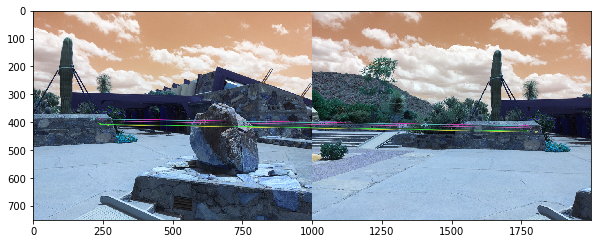

Homography matrix [[ 3.25093710e+00  6.37875565e-01 -2.05909043e+03]
 [ 3.73842047e-01  4.11738351e+00 -8.23389890e+02]
 [ 1.06352799e-03  2.84741442e-03  1.00000000e+00]]


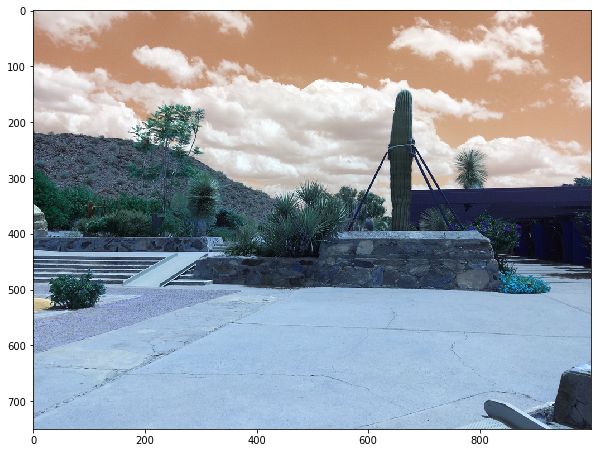

2

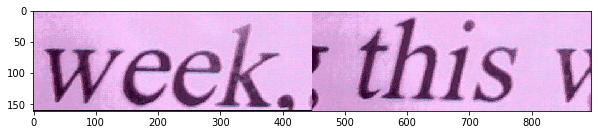

Less than 5 good points, cannot find homography matrix
Could not perform stitching


In [0]:
num_of_set = 4
for i in range(num_of_set):
    path = '/content/drive/My Drive/computer_vision/assignments/assignment_2/images/image_mosaicing/'
    sceneimages = glob.glob(path+'img' + str(i+1) + '*.jpg')
    images1 = []
    for j in range(len(sceneimages)):
        images1.append(cv.imread(path+'img' + str(i+1) + '_' + str(j+1) + '.jpg'))
    #print(len(images1))
    stiched_image = image_stitching(images1)
#cv.imwrite("landscape.jpg", stiched_image)

## Mosaicing using SURF features

*   On Given test images
*   On images captured from my camera

In [0]:
num_of_set = 4
for i in range(num_of_set):
    path = '/content/drive/My Drive/computer_vision/assignments/assignment_2/images/image_mosaicing/'
    sceneimages = glob.glob(path+'img' + str(i+1) + '*.jpg')
    images1 = []
    for j in range(len(sceneimages)):
        images1.append(cv.imread(path+'img' + str(i+1) + '_' + str(j+1) + '.jpg'))
    #print(len(images1))
    stiched_image = image_stitching(images1, feature_type='surf')

## Mosaicing on captured images

*   Using SIFT features
*   Using SURF features



3


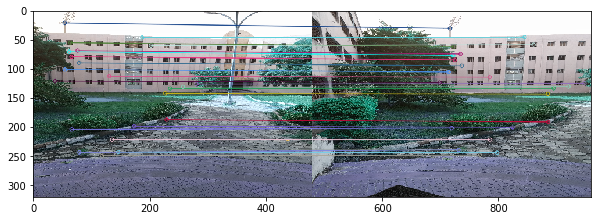

Homography matrix [[ 7.06259665e-01 -4.01509598e-02  1.91415265e+02]
 [-9.20956452e-02  8.93927791e-01  1.59873686e+01]
 [-6.24764700e-04 -2.77368160e-05  1.00000000e+00]]
swap


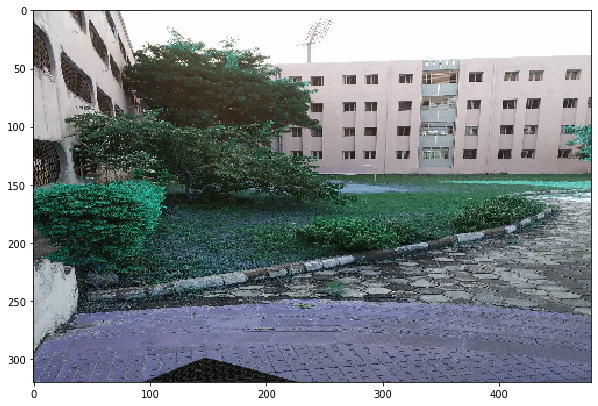

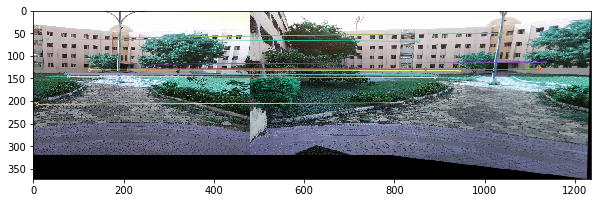

Homography matrix [[ 4.87637230e-01 -1.39816253e-01  3.57062589e+02]
 [-1.60444861e-01  9.07076872e-01  1.51643705e+01]
 [-1.10329125e-03 -9.33204362e-06  1.00000000e+00]]
swap


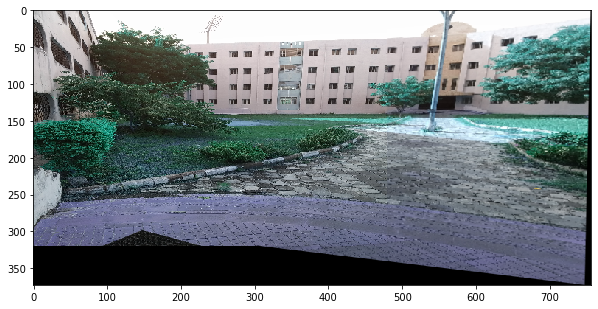

In [0]:
num_of_set = 1
for i in range(num_of_set):
    path = '/content/drive/My Drive/computer_vision/assignments/assignment_2/images/image_mosaicing/myimages/'
    sceneimages = glob.glob(path+'rawimage*.png')
    images1 = []
    print(len(sceneimages))
    for j in range(len(sceneimages)):
        images1.append(cv.imread(path+'rawimage_' + str(j) + '.png'))
    #print(len(images1))
    stiched_image = image_stitching(images1, factor = 0.4)